In [2]:
import pandas as pd
import numpy as np

print("=== STEP 1: LOAD DATA ===")
df = pd.read_csv("telecom.csv")
print("Initial shape:", df.shape)
print(df.head())

print("\n=== STEP 2: CHECK COLUMN INFORMATION ===")
print(df.info())

print("\n=== STEP 3: CHECK MISSING VALUES ===")
print(df.isnull().sum())

# Fill numeric missing values with median
numeric_cols = df.select_dtypes(include=['int64','float64']).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# Fill categorical missing values with mode (most frequent)
categorical_cols = df.select_dtypes(include=['object']).columns
df[categorical_cols] = df[categorical_cols].fillna(df[categorical_cols].mode().iloc[0])

print("\n=== Missing values after cleaning ===")
print(df.isnull().sum())

print("\n=== STEP 4: REMOVE DUPLICATES ===")
before = df.shape[0]
df = df.drop_duplicates()
after = df.shape[0]
print(f"Removed duplicates: {before - after}")

print("\n=== STEP 5: STANDARDIZE LABEL VALUES ===")
if "Churn" in df.columns:
    df["Churn"] = df["Churn"].astype(str).str.strip().str.lower()
    df["Churn"] = df["Churn"].replace({"yes":1, "no":0, "true":1, "false":0})
    df["Churn"] = df["Churn"].fillna(0)
    df["Churn"] = df["Churn"].astype(int)
    print("Unique Churn values:", df["Churn"].unique())
else:
    print("⚠️ WARNING: 'Churn' column not found!")

print("\n=== STEP 6: CHECK CONSTANT / ZERO-VARIANCE COLUMNS ===")
for col in df.columns:
    if df[col].nunique() <= 1:
        print("Dropping useless column:", col)
        df = df.drop(col, axis=1)

print("\n=== STEP 7: OUTLIER CHECK (IQR method) ===")
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    low = Q1 - 1.5 * IQR
    high = Q3 + 1.5 * IQR
    outliers = ((df[col] < low) | (df[col] > high)).sum()
    if outliers > 0:
        print(f"Potential outliers in {col}: {outliers}")

print("\n=== STEP 8: FINAL DATA VALIDATION ===")
print("Final dataset shape:", df.shape)
print("Sample rows:")
print(df.sample(5))
print("\nUnique values per column:")
print(df.nunique())
print("\nData types:")
print(df.dtypes)

print("\n=== STEP 9: SAVE CLEANED DATASET ===")
df.to_csv("telecom_clean.csv", index=False)
print("Saved cleaned dataset as telecom_clean.csv")


=== STEP 1: LOAD DATA ===
Initial shape: (7043, 21)
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupp

C:\Users\parth\AppData\Local\Temp\ipykernel_5172\1371187726.py:35: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["Churn"] = df["Churn"].replace({"yes":1, "no":0, "true":1, "false":0})


In [3]:
# ==================================================
#  1) Load cleaned dataset
# ==================================================
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

df = pd.read_csv("telecom_clean.csv")
print("Final dataset shape:", df.shape)

# ==================================================
#  2) Separate features and target
# ==================================================
X = df.drop("Churn", axis=1)
y = df["Churn"]

# ==================================================
#  3) Identify categorical & numeric features
# ==================================================
cat_features = X.select_dtypes(include=['object']).columns
num_features = X.select_dtypes(include=['int64','float64']).columns

# ==================================================
#  4) Train / Test Split
# ==================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ==================================================
#  5) Preprocessing Pipeline (Encoding + Scaling)
# ==================================================
preprocess = ColumnTransformer(
    transformers=[
        ('categorical', OneHotEncoder(handle_unknown='ignore'), cat_features),
        ('numerical', StandardScaler(), num_features)
    ]
)

# ==================================================
#  6) Logistic Regression
# ==================================================
log_model = Pipeline(steps=[
    ('preprocess', preprocess),
    ('classifier', LogisticRegression(max_iter=500))
])
log_model.fit(X_train, y_train)

y_pred_log = log_model.predict(X_test)
y_prob_log = log_model.predict_proba(X_test)[:,1]

print("\n===== Logistic Regression Results =====")
print("Precision:", precision_score(y_test, y_pred_log))
print("Recall:", recall_score(y_test, y_pred_log))
print("F1 Score:", f1_score(y_test, y_pred_log))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_log))

# ==================================================
#  7) Random Forest Classifier
# ==================================================
rf_model = Pipeline(steps=[
    ('preprocess', preprocess),
    ('classifier', RandomForestClassifier(n_estimators=200, random_state=42))
])
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:,1]

print("\n===== Random Forest Results =====")
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("F1 Score:", f1_score(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))


Final dataset shape: (7043, 21)

===== Logistic Regression Results =====
Precision: 0.7025316455696202
Recall: 0.5951742627345844
F1 Score: 0.6444121915820029
ROC-AUC: 0.8612432328920265

===== Random Forest Results =====
Precision: 0.6707317073170732
Recall: 0.44235924932975873
F1 Score: 0.5331179321486268
ROC-AUC: 0.846298663657913


In [4]:
import numpy as np

# Extract names after encoding
encoded_cols = list(rf_model.named_steps['preprocess']
                    .named_transformers_['categorical']
                    .get_feature_names_out(cat_features)) + list(num_features)

# Get feature importance values
importances = rf_model.named_steps['classifier'].feature_importances_
feat_imp = pd.DataFrame({
    'Feature': encoded_cols,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\nTop 20 churn-impacting features:")
print(feat_imp.head(20))



Top 20 churn-impacting features:
                                     Feature  Importance
10976                                 tenure    0.073789
10977                         MonthlyCharges    0.054212
5666                 Contract_Month-to-month    0.030764
5673          PaymentMethod_Electronic check    0.019481
5646             InternetService_Fiber optic    0.016096
5668                       Contract_Two year    0.015721
5648                       OnlineSecurity_No    0.015535
5657                          TechSupport_No    0.015279
5650                      OnlineSecurity_Yes    0.014893
5651                         OnlineBackup_No    0.011945
5654                     DeviceProtection_No    0.011878
5667                       Contract_One year    0.011698
5659                         TechSupport_Yes    0.011475
5670                    PaperlessBilling_Yes    0.011002
10975                          SeniorCitizen    0.010489
5635                             gender_Male    0.0097

In [5]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_rf)
print("\nConfusion Matrix:")
print(cm)



Confusion Matrix:
[[955  81]
 [208 165]]


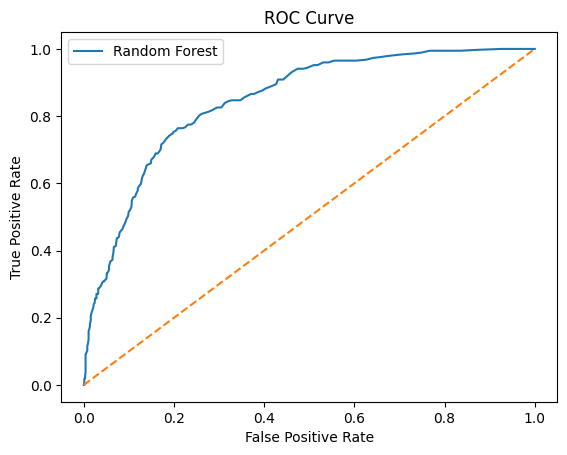

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_prob_rf)

plt.figure()
plt.plot(fpr, tpr, label="Random Forest")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [7]:
import pickle

with open('churn_model.pkl', 'wb') as file:
    pickle.dump(rf_model, file)

print("Model saved as churn_model.pkl")


Model saved as churn_model.pkl
